In [2]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

# Load Tags Data

In [3]:
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "..", "data", "tags.csv"))
tags.drop('timestamp', axis=1, inplace=True)
tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [4]:
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

,title,genres
movieId,,
8914,Primer (2004),Drama SciFi


In [5]:
print(tags.shape)
tags['tag'] = tags['tag'].astype(str)
tags.dtypes

(465564, 3)


userId      int64
movieId     int64
tag        object
dtype: object

In [6]:
tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


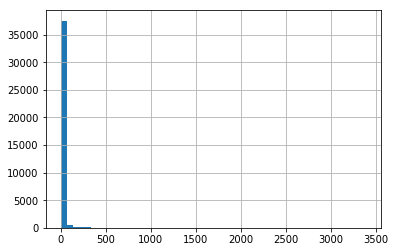

In [7]:
tags.tag.value_counts().hist(bins=50)

In [8]:
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 19545 unique movies


,movieId,tag
15288,96662,{Finnish music documentary disability document...
5679,6689,{project greenlight high school Project Greenl...
6566,7938,{jesus atmospheric austere bleak cerebral deli...
5,6,{realistic action Al Pacino Michael Mann Rober...
10304,55036,{Robert Harmon}
7933,27002,{netflix astronauts history made for TV NASA S...
5468,6449,{alcoholism}
10708,58975,{to see: b-grade horror Nudity (Topless - Brie...
6083,7142,{Honor Jessica Alba stupid dance movie dance b...
16532,103998,{Michael Apted}


In [9]:
# add genres
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,movieId,tag,document
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,{Watched computer animation Disney animated fe...,{Watched computer animation Disney animated fe...
1,Jumanji (1995),Adventure Children Fantasy,2,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
2,Grumpier Old Men (1995),Comedy Romance,3,{old people that is actually funny sequel feve...,{old people that is actually funny sequel feve...


# TFIDF
Vectorize tags and genres into unigrams and bigrams with the TFIDF tokenizer.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        min_df=5,
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags.document)
print(tfidf_matrix.shape)

(19545, 17985)


In [19]:
tfidf.vocabulary_

{'watched': 17439,
 'computer': 4108,
 'animation': 1103,
 'disney': 5090,
 'animated': 1094,
 'feature': 6489,
 'pixar': 12406,
 'tã': 16780,
 'leoni': 9825,
 'does': 5219,
 'star': 15256,
 'movie': 11076,
 'family': 6327,
 'tom': 16356,
 'hanks': 7862,
 'witty': 17692,
 'adventure': 655,
 'clever': 3671,
 'comedy': 3818,
 'fantasy': 6367,
 'bright': 2670,
 'daring': 4651,
 'rescues': 13543,
 'fanciful': 6359,
 'heroic': 8063,
 'mission': 10899,
 'humorous': 8422,
 'light': 9937,
 'rousing': 13970,
 'toys': 16542,
 'come': 3812,
 'life': 9921,
 'unlikely': 16883,
 'friendships': 7024,
 'warm': 17401,
 'time': 16305,
 'travel': 16582,
 'kids': 9461,
 'tim': 16298,
 'allen': 904,
 'action': 444,
 'figure': 6647,
 'cg': 3107,
 'toy': 16541,
 'woody': 17759,
 'hurts': 8453,
 'children': 3317,
 'funny': 7091,
 '3d': 288,
 'cartoon': 3005,
 'ya': 17860,
 'boy': 2585,
 'cgi': 3109,
 'rated': 13201,
 'lots': 10122,
 'heart': 7970,
 'want': 17324,
 'imdb': 8589,
 '250': 229,
 'buddy': 2772,
 '

# SVD
Compress TFIDF matrix with SVD to find latent topics in the text. 

In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_matrix)
print(latent_matrix.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance by the SVD: {}%".format(int(explained_variance * 100)))

(19545, 100)
Explained variance by the SVD: 24%


In [21]:
latent_df = pd.DataFrame(latent_matrix, index=movie_id)
print(latent_df.shape)
latent_df.head(3)

TypeError: Index(...) must be called with a collection of some kind, 8914 was passed

# Find Similar Movies in Latent Space

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = pd.DataFrame(cosine_similarity(X=latent_matrix), index=movie_id)
cosine_sim.columns = movie_id
cosine_sim

movieId,1,2,3,4,5,6,7,8,9,10,...,130984,131011,131013,131015,131031,131054,131082,131164,131170,131258
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.253159,0.129774,0.051246,0.208588,0.083191,-0.002099,0.062399,0.026496,0.012911,...,0.033924,0.066342,0.031602,0.026049,0.003322,0.141568,0.009045,0.003340,-0.036928,0.087443
2,0.253159,1.000000,0.104501,0.074256,0.195919,0.071624,0.136247,0.294576,0.099550,0.006810,...,0.221904,-0.002204,-0.060893,0.054219,-0.020165,0.362859,-0.023761,0.014583,0.187094,0.115080
3,0.129774,0.104501,1.000000,0.667523,0.435026,0.110914,0.400441,0.011858,-0.000107,0.004409,...,0.013981,0.043618,0.457371,0.035425,0.002842,-0.016807,-0.014788,0.012890,-0.060200,-0.006203
4,0.051246,0.074256,0.667523,1.000000,0.294468,0.088173,0.377629,0.003318,0.058173,0.002286,...,-0.007231,0.073420,0.249980,0.039947,0.062970,-0.018059,0.041215,0.018443,-0.014234,0.003122
5,0.208588,0.195919,0.435026,0.294468,1.000000,0.368899,0.328806,0.080434,0.022875,0.052248,...,0.143322,0.059080,0.356646,0.181584,-0.139501,0.108349,-0.119276,-0.000427,-0.031591,0.017664
6,0.083191,0.071624,0.110914,0.088173,0.368899,1.000000,0.245797,-0.004670,0.054648,0.045312,...,0.065372,0.304257,0.022769,0.128510,0.048048,-0.009537,0.070058,0.048048,-0.001135,0.018445
7,-0.002099,0.136247,0.400441,0.377629,0.328806,0.245797,1.000000,0.156386,-0.049751,0.049164,...,0.012590,0.098765,0.153382,0.110487,0.119050,-0.023131,0.090213,0.029148,0.035108,0.030903
8,0.062399,0.294576,0.011858,0.003318,0.080434,-0.004670,0.156386,1.000000,0.014467,0.003803,...,-0.015518,0.029069,0.029549,-0.006912,-0.004230,0.225788,-0.036169,-0.028100,-0.012280,0.260523
9,0.026496,0.099550,-0.000107,0.058173,0.022875,0.054648,-0.049751,0.014467,1.000000,0.012781,...,0.048722,-0.073840,0.041649,-0.011038,-0.029892,-0.005620,-0.007400,0.001282,0.019792,-0.004421


In [15]:
def find_similar_movies(movie_id, cosine_sim, movies):
    
    #get similarity score vector for requested movie
    sim_series = pd.DataFrame(cosine_sim.loc[movie_id].sort_values(ascending=False))
    sim_series.columns = ["sim_score"]
    sim_series.head()
     
    #return detailed dataframe with similarity scores for reuqested movie
    sim_df = pd.merge(movies, sim_series, left_index=True, right_index=True)
    sim_df.sort_values(by="sim_score", ascending=False, inplace=True)
    return sim_df

In [24]:
movie_id = 8914 #primer
movie_id = 79132 #inception
movie_id = 1380 #grease
movie_id = 51540 #zodiac
find_similar_movies(movie_id, cosine_sim, movies).head(100)

,title,genres,sim_score
movieId,,,
51540,Zodiac (2007),Crime Drama Thriller,1.000000
6887,Radio (2003),Drama,0.784352
3105,Awakenings (1990),Drama Mystery,0.764324
1061,Sleepers (1996),Thriller,0.761477
51304,Karla (2006),Crime Drama Thriller,0.741916
7618,Chaplin (1992),Drama,0.731154
42710,Ted Bundy (2002),Crime Drama Thriller,0.716392
300,Quiz Show (1994),Drama,0.696288
32389,Deep Crimson (Profundo carmesí) (1996),Crime Drama,0.691624
